<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/03_Evaluate_1B_CARBON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-1B Evaluation
## 03 - Measuring Environmental Impact & Inference Performance

### Exploring energy efficiency of width-pruned GLU models
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** GPU L4 (or T4)

**Models to Profile:**
- Llama-3.2-1B (baseline)
- Llama-3.2-1B-pruned-40%

**Workloads (2 representative):**
- GSM8K: Math reasoning (100 prompts, 100 max tokens)
- MMLU: Knowledge QA (100 prompts, 50 max tokens)

**Metrics Collected:**
- Energy consumption (kWh via CodeCarbon)
- Throughput (tokens/second)
- Latency (TTFT - Time To First Token)
- Memory footprint (GPU allocation)

**Estimated Runtime:** ~1-2 hours total

---

## 📋 Notebook Objective

This notebook conducts a comprehensive evaluation of the Llama-3.2-1B model family across three pruning levels (20%, 40%, 60%) to determine:

1. **Performance degradation patterns** across different pruning intensities
2. **Optimal expansion ratio** for GLU-MLP layers (hypothesis: 140%)
3. **Task-specific resilience** to pruning (knowledge vs. algorithmic tasks)
4. **Which models merit uploading to HuggingFace Hub** for Phase 2

### Key Features:
- ✅ **Checkpoint/Resume Support:** Survives Colab disconnections
- ✅ **On-the-fly Pruning:** No need to pre-create models
- ✅ **Robust Error Handling:** Continues if individual benchmarks fail
- ✅ **Progress Tracking:** Live updates and detailed logging

### Results will answer:
- Does 40% pruning (140% expansion) truly outperform other levels?
- Which benchmarks are most sensitive to pruning?
- Should we upload non-star models to HF, or only the 40% version?

---

**Note:** This evaluation uses the MAW (Maximum Absolute Weight) neuron selection method, validated in Notebook 00 as the optimal approach for GLU architectures.

---

# 1. Setup & Installation

In [1]:
# Install required libraries
!pip install -q optipfair
!pip install -q lm-eval
!pip install -q langdetect
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Mount Google Drive for checkpoint persistence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

✅ utils.py downloaded successfully


In [5]:
# Import core libraries and utilities
import torch
import json
import pandas as pd
from datetime import datetime
from pathlib import Path

# Import our utility functions
from utils import (
    EXPERIMENT_CONFIG_CARBON,
    BENCHMARKS_CARBON,
    load_or_create_model,
    run_carbon_profiling,
    run_robust_evaluation,
    clear_gpu_cache,
    get_model_stats,
    format_results_table
)

print("✅ All imports successful")
print(f"📱 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All imports successful
📱 Device: GPU
   GPU: NVIDIA L4
   Memory: 23.8 GB


# 2. Configuration & Planning

This section filters the experiment configuration for 1B models and displays the profiling plan.

In [7]:
# Filter configuration for 1B models only
models_1b = [
    config for config in EXPERIMENT_CONFIG_CARBON
    if "1B" in config["base_model"] and "3B" not in config["base_model"] and "Instruct" not in config["base_model"]
]

print(f"\n{'='*70}")
print("📊 EVALUATION PLAN: Llama-3.2-1B Family")
print(f"{'='*70}\n")

print(f"Total models to evaluate: {len(models_1b) + 1}")  # +1 for base model
print(f"Benchmarks per model: {len(BENCHMARKS_CARBON)}")
print(f"Total evaluations: {(len(models_1b) + 1) * len(BENCHMARKS_CARBON)}")
print(f"Estimated runtime: ~1-1.5 hours\n")

# Display models table
print("Models to profile:")
print("-" * 70)
print(f"{'Model':<40} {'Pruning':<10} {'Star':<6}")
print("-" * 70)

for config in models_1b:
    if config['pruning_pct'] == 0:
        model_name = "Llama-3.2-1B (baseline)"
    else:
        model_name = f"Llama-3.2-1B-pruned-{config['pruning_pct']}%"

    pruning = f"{config['pruning_pct']}%"
    star = "⭐ Yes" if config['is_star'] else "No"
    print(f"{model_name:<40} {pruning:<10} {star:<6}")

print("-" * 70)

# Display workloads
print("\nWorkloads to run:")
print("-" * 70)
for i, workload in enumerate(BENCHMARKS_CARBON, 1):
    name = workload['name']
    prompts = workload['num_prompts']
    tokens = workload['max_new_tokens']
    desc = workload['description']
    print(f"{i}. {name:<25} {prompts} prompts, {tokens} tokens - {desc}")
print("-" * 70)

print("\n⚙️ Configuration:")
print(f"   - Neuron selection method: MAW (Maximum Absolute Weight)")
print(f"   - Checkpointing: Enabled (per-workload granularity)")
print(f"   - Model creation: On-the-fly pruning (no pre-creation needed)")
print(f"   - GPU warm-up: First 5 prompts excluded from metrics")
print(f"   - Energy tracking: CodeCarbon")


📊 EVALUATION PLAN: Llama-3.2-1B Family

Total models to evaluate: 3
Benchmarks per model: 2
Total evaluations: 6
Estimated runtime: ~1-1.5 hours

Models to profile:
----------------------------------------------------------------------
Model                                    Pruning    Star  
----------------------------------------------------------------------
Llama-3.2-1B (baseline)                  0%         No    
Llama-3.2-1B-pruned-40%                  40%        ⭐ Yes 
----------------------------------------------------------------------

Workloads to run:
----------------------------------------------------------------------
1. gsm8k_workload            100 prompts, 100 tokens - Math reasoning workload
2. mmlu_workload             100 prompts, 50 tokens - Knowledge QA workload
----------------------------------------------------------------------

⚙️ Configuration:
   - Neuron selection method: MAW (Maximum Absolute Weight)
   - Checkpointing: Enabled (per-workload granula

In [9]:
# Setup checkpoint paths (manual construction since helpers are internal)
BASE_CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints"
RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

# Carbon-specific subdirectory
CHECKPOINT_DIR = f"{BASE_CHECKPOINT_DIR}/1b_carbon"

# Create directories if they don't exist
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

print(f"✅ Checkpoint directory: {CHECKPOINT_DIR}")
print(f"✅ Results directory: {RESULTS_DIR}")

# ============================================================================
# CONSTRUCT CHECKPOINT PATHS DYNAMICALLY FROM models_1b
# ============================================================================
checkpoint_paths = {}

for config in models_1b:
    pruning_pct = config['pruning_pct']

    # Create key: "baseline" for 0%, "{X}pct" for others
    if pruning_pct == 0:
        key = "baseline"
        filename = "llama_3.2_1b_baseline_carbon.json"
    else:
        key = f"{pruning_pct}pct"
        filename = f"llama_3.2_1b_pruned_{pruning_pct}pct_carbon.json"

    checkpoint_paths[key] = f"{CHECKPOINT_DIR}/{filename}"

print(f"\n📂 Auto-generated {len(checkpoint_paths)} checkpoint paths:")
for key, path in checkpoint_paths.items():
    exists = "✅ Exists" if Path(path).exists() else "🆕 New"
    print(f"  {key:<10}: {exists}")

✅ Checkpoint directory: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon
✅ Results directory: /content/drive/MyDrive/glu_pruning/results

📂 Auto-generated 2 checkpoint paths:
  baseline  : 🆕 New
  40pct     : 🆕 New


# 3. Baseline Evaluation

Evaluate the original Llama-3.2-1B model to establish performance baseline.

In [ ]:
print(f"\n{'='*70}")
print("📊 PHASE 1: BASELINE PROFILING")
print(f"{'='*70}\n")

BASE_MODEL_ID = "meta-llama/Llama-3.2-1B"

# Load base model
from transformers import AutoModelForCausalLM, AutoTokenizer

print(f"Loading base model: {BASE_MODEL_ID}...")
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.bfloat16,  # Use bfloat16 for A100, float16 for T4
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("✅ Model loaded successfully")

# Display model statistics
base_stats = get_model_stats(base_model)
print(f"\n📈 Model Statistics:")
print(f"   Parameters: {base_stats['total_parameters']:,}")
print(f"   Size: {base_stats['size_gb']:.2f} GB")

# Run carbon profiling with checkpointing
baseline_results = run_carbon_profiling(
    model=base_model,
    tokenizer=tokenizer,
    workloads=BENCHMARKS_CARBON,
    checkpoint_path=checkpoint_paths["baseline"],
    model_name="Llama-3.2-1B-baseline"
)

print(f"\n{'='*70}")
print("✅ BASELINE PROFILING COMPLETED")
print(f"{'='*70}\n")

# Display results summary
print("Results Summary:")
for workload_name, metrics in baseline_results.items():
    print(f"\n{workload_name}:")
    print(f"  Energy: {metrics['energy_kwh']:.6f} kWh")
    print(f"  Throughput: {metrics['throughput_tokens_per_sec']:.2f} tok/s")
    print(f"  Avg TTFT: {metrics['avg_ttft_ms']:.2f} ms")
    print(f"  Memory: {metrics['model_size_gb']:.2f} GB")

# Clear memory
del base_model
clear_gpu_cache()
print("\n🧹 Memory cleared, ready for pruned models")

# 4. Pruned Models Evaluation Loop

Profile the pruned variants using on-the-fly pruning with OptiPFair.

In [12]:
print(f"\n{'='*70}")
print("📊 PHASE 2: PRUNED MODELS PROFILING")
print(f"{'='*70}\n")

# Store all results for final comparison
all_results = {
    "baseline": baseline_results
}

# Filter out baseline (already done)
pruned_models = [m for m in models_1b if m['pruning_pct'] > 0]

# Evaluate each pruned model
for i, config in enumerate(pruned_models, 1):
    model_name = f"Llama-3.2-1B-pruned-{config['pruning_pct']}%"
    pruning_pct = config['pruning_pct']
    is_star = config['is_star']

    print(f"\n{'─'*70}")
    print(f"🔄 PROFILING MODEL {i}/{len(pruned_models)}: {model_name}")
    print(f"   Pruning: {pruning_pct}% | Star: {'⭐' if is_star else 'No'}")
    print(f"{'─'*70}\n")

    try:
        # Load or create model using utility function
        model, tokenizer, stats = load_or_create_model(config, device="auto")

        # Display model statistics
        print(f"\n📈 Model Statistics:")
        print(f"   Parameters: {stats['total_parameters']:,}")
        print(f"   Size: {stats['size_gb']:.2f} GB")
        if 'pruning_stats' in stats:
            print(f"   Reduction: {stats['pruning_stats']['percentage_reduction']:.2f}%")
        print(f"   Source: {stats['source']}\n")

        # Determine checkpoint key
        checkpoint_key = f"{pruning_pct}pct"

        # Run profiling with checkpointing
        results = run_carbon_profiling(
            model=model,
            tokenizer=tokenizer,
            workloads=BENCHMARKS_CARBON,
            checkpoint_path=checkpoint_paths[checkpoint_key],
            model_name=model_name
        )

        # Store results
        all_results[checkpoint_key] = results

        print(f"\n✅ {model_name} profiling completed")

        # Display results summary
        print("\nResults Summary:")
        for workload_name, metrics in results.items():
            print(f"\n{workload_name}:")
            print(f"  Energy: {metrics['energy_kwh']:.6f} kWh")
            print(f"  Throughput: {metrics['throughput_tokens_per_sec']:.2f} tok/s")
            print(f"  Avg TTFT: {metrics['avg_ttft_ms']:.2f} ms")
            print(f"  Memory: {metrics['model_size_gb']:.2f} GB")

        # Clear memory before next model
        del model
        clear_gpu_cache()

    except Exception as e:
        print(f"\n❌ ERROR profiling {model_name}: {str(e)}")
        print("   Continuing with next model...\n")
        clear_gpu_cache()
        continue

print(f"\n{'='*70}")
print("✅ ALL MODELS PROFILED")
print(f"{'='*70}\n")


📊 PHASE 2: PRUNED MODELS PROFILING


──────────────────────────────────────────────────────────────────────
🔄 PROFILING MODEL 1/1: Llama-3.2-1B-pruned-40%
   Pruning: 40% | Star: ⭐
──────────────────────────────────────────────────────────────────────


Loading model: peremartra/Llama-3.2-1B-pruned-40pct
  Base: meta-llama/Llama-3.2-1B
  Pruning: 40%
  Star model: ⭐ Yes

📥 Attempting to load from HF Hub: peremartra/Llama-3.2-1B-pruned-40pct
⚠️  HF Hub load failed: peremartra/Llama-3.2-1B-pruned-40pct is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`
   Falling back to on-the-fly pruning...
🔧 Creating model via on-the-fly pruning...
✂️  Pruning with MAW method (40%)...


Pruning layers: 100%|██████████| 16/16 [00:04<00:00,  3.91it/s]


✅ Model created
   Original params: 1,235,814,400
   Pruned params: 913,770,496
   Reduction: 26.06%

📈 Model Statistics:
   Parameters: 913,770,496
   Size: 1.70 GB
   Reduction: 26.06%
   Source: on_the_fly_pruning

🆕 Creating new checkpoint: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon/llama_3.2_1b_pruned_40pct_carbon.json
✅ Loaded checkpoint. Completed: 0/2 workloads

🚀 Starting profiling: 2 workloads remaining

[1/2] Profiling: gsm8k_workload
----------------------------------------------------------------------
   Clearing GPU cache...


[codecarbon WARNING @ 10:16:25] Multiple instances of codecarbon are allowed to run at the same time.


🧹 GPU memory cleared. Available: 23.80 GB


[codecarbon WARNING @ 10:16:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:16:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 10:16:26] No CPU tracking mode found. Falling back on CPU constant mode.


   Loading 100 prompts from gsm8k...
   Running inference...
✅ gsm8k_workload completed
   Energy: 0.002294 kWh
   Throughput: 84.82 tok/s
   Avg TTFT: 1449.71 ms
   Memory: 1.70 GB

[2/2] Profiling: mmlu_workload
----------------------------------------------------------------------
   Clearing GPU cache...
🧹 GPU memory cleared. Available: 23.80 GB


[codecarbon WARNING @ 10:18:55] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 10:18:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:18:56] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 10:18:56] No CPU tracking mode found. Falling back on CPU constant mode.


   Loading 100 prompts from mmlu...
   Running inference...
✅ mmlu_workload completed
   Energy: 0.001495 kWh
   Throughput: 84.14 tok/s
   Avg TTFT: 929.39 ms
   Memory: 1.70 GB

🎉 ALL WORKLOADS COMPLETED!


✅ Llama-3.2-1B-pruned-40% profiling completed

Results Summary:

gsm8k_workload:
  Energy: 0.002294 kWh
  Throughput: 84.82 tok/s
  Avg TTFT: 1449.71 ms
  Memory: 1.70 GB

mmlu_workload:
  Energy: 0.001495 kWh
  Throughput: 84.14 tok/s
  Avg TTFT: 929.39 ms
  Memory: 1.70 GB
🧹 GPU memory cleared. Available: 23.80 GB

✅ ALL MODELS PROFILED



# 5. Results Consolidation & Export

Consolidate all evaluation results and export to CSV for analysis.

In [13]:
print(f"\n{'='*70}")
print("📊 CONSOLIDATING CARBON PROFILING RESULTS")
print(f"{'='*70}\n")

# ============================================================================
# BUILD DYNAMIC MAPPINGS FROM models_1b
# ============================================================================
model_names = {}
model_pruning = {}
model_is_star = {}

for config in models_1b:
    pruning_pct = config['pruning_pct']

    # Create key
    key = "baseline" if pruning_pct == 0 else f"{pruning_pct}pct"

    # Build mappings
    if pruning_pct == 0:
        model_names[key] = "Llama-3.2-1B"
    else:
        model_names[key] = f"Llama-3.2-1B-pruned-{pruning_pct}%"

    model_pruning[key] = pruning_pct
    model_is_star[key] = config['is_star']

print(f"✅ Auto-generated mappings for {len(model_names)} models")

# ============================================================================
# CONSOLIDATE RESULTS
# ============================================================================
consolidated_data = []

# Process each model's results
for model_key, workload_results in all_results.items():
    display_name = model_names.get(model_key, model_key)
    pruning_pct = model_pruning.get(model_key, 0)
    is_star = model_is_star.get(model_key, False)

    for workload_name, metrics in workload_results.items():
        row = {
            "model": display_name,
            "pruning_pct": pruning_pct,
            "is_star": is_star,
            "workload": workload_name,
            **metrics  # Unpack all metrics
        }
        consolidated_data.append(row)

# Create DataFrame
df = pd.DataFrame(consolidated_data)

# Sort by pruning_pct and workload
df = df.sort_values(by=["pruning_pct", "workload"]).reset_index(drop=True)

print(f"✅ Consolidated {len(df)} result rows")
print(f"   Models: {df['model'].nunique()}")
print(f"   Workloads: {df['workload'].nunique()}")

# Display preview
print("\nDataFrame Preview:")
print(df[['model', 'workload', 'energy_kwh', 'throughput_tokens_per_sec', 'avg_ttft_ms', 'model_size_gb']].head(10))

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"{RESULTS_DIR}/carbon_1b_results_{timestamp}.csv"
df.to_csv(csv_path, index=False)
print(f"\n💾 Results saved to: {csv_path}")

# Also save a "latest" version
latest_path = f"{RESULTS_DIR}/carbon_1b_results_latest.csv"
df.to_csv(latest_path, index=False)
print(f"💾 Latest results: {latest_path}")

print(f"\n{'='*70}")
print("✅ PROFILING COMPLETE - ALL RESULTS SAVED")
print(f"{'='*70}\n")


📊 CONSOLIDATING CARBON PROFILING RESULTS

✅ Auto-generated mappings for 2 models
✅ Consolidated 4 result rows
   Models: 2
   Workloads: 2

DataFrame Preview:
                     model        workload  energy_kwh  \
0             Llama-3.2-1B  gsm8k_workload    0.002023   
1             Llama-3.2-1B   mmlu_workload    0.001738   
2  Llama-3.2-1B-pruned-40%  gsm8k_workload    0.002294   
3  Llama-3.2-1B-pruned-40%   mmlu_workload    0.001495   

   throughput_tokens_per_sec  avg_ttft_ms  model_size_gb  
0                  93.819827  1139.371470       2.301884  
1                  82.884267   977.979924       2.301884  
2                  84.819280  1449.707335       1.702030  
3                  84.144610   929.391213       1.702030  

💾 Results saved to: /content/drive/MyDrive/glu_pruning/results/carbon_1b_results_20251105_102324.csv
💾 Latest results: /content/drive/MyDrive/glu_pruning/results/carbon_1b_results_latest.csv

✅ PROFILING COMPLETE - ALL RESULTS SAVED



In [14]:
print(f"\n{'='*70}")
print("📈 CARBON & PERFORMANCE ANALYSIS")
print(f"{'='*70}\n")

# Calculate averages per model across workloads
summary_data = []

# Use dynamic keys from all_results
for model_key in all_results.keys():
    workload_results = all_results[model_key]

    # Aggregate metrics across workloads
    total_energy = sum(m['energy_kwh'] for m in workload_results.values())
    avg_throughput = sum(m['throughput_tokens_per_sec'] for m in workload_results.values()) / len(workload_results)
    avg_ttft = sum(m['avg_ttft_ms'] for m in workload_results.values()) / len(workload_results)
    model_size = list(workload_results.values())[0]['model_size_gb']  # Same for all workloads

    summary = {
        "model": model_names.get(model_key, model_key),
        "pruning_pct": model_pruning.get(model_key, 0),
        "is_star": model_is_star.get(model_key, False),
        "total_energy_kwh": total_energy,
        "avg_throughput_tok_s": avg_throughput,
        "avg_ttft_ms": avg_ttft,
        "model_size_gb": model_size
    }
    summary_data.append(summary)

# Sort by pruning_pct for consistent display
summary_df = pd.DataFrame(summary_data).sort_values('pruning_pct').reset_index(drop=True)

print("Performance Summary:")
print("-" * 90)
print(summary_df.to_string(index=False, float_format="%.4f"))
print("-" * 90)

# Calculate improvements vs baseline
baseline_row = summary_df[summary_df['pruning_pct'] == 0].iloc[0]

print(f"\n💡 Improvements vs. Baseline:")
print("-" * 90)

for _, row in summary_df.iterrows():
    if row['pruning_pct'] == 0:
        continue

    energy_reduction = ((baseline_row['total_energy_kwh'] - row['total_energy_kwh']) / baseline_row['total_energy_kwh']) * 100
    throughput_change = ((row['avg_throughput_tok_s'] - baseline_row['avg_throughput_tok_s']) / baseline_row['avg_throughput_tok_s']) * 100
    ttft_change = ((row['avg_ttft_ms'] - baseline_row['avg_ttft_ms']) / baseline_row['avg_ttft_ms']) * 100
    size_reduction = ((baseline_row['model_size_gb'] - row['model_size_gb']) / baseline_row['model_size_gb']) * 100

    star_marker = "⭐" if row['is_star'] else ""
    print(f"\n{row['model']} {star_marker}")
    print(f"  Energy: {energy_reduction:+.2f}% ({'✅ Lower' if energy_reduction > 0 else '❌ Higher'})")
    print(f"  Throughput: {throughput_change:+.2f}% ({'✅ Faster' if throughput_change > 0 else '⚠️ Slower'})")
    print(f"  Latency (TTFT): {ttft_change:+.2f}% ({'✅ Lower' if ttft_change < 0 else '⚠️ Higher'})")
    print(f"  Model Size: {size_reduction:+.2f}% ({'✅ Smaller' if size_reduction > 0 else '❌ Larger'})")

print("\n" + "-" * 90)


📈 CARBON & PERFORMANCE ANALYSIS

Performance Summary:
------------------------------------------------------------------------------------------
                  model  pruning_pct  is_star  total_energy_kwh  avg_throughput_tok_s  avg_ttft_ms  model_size_gb
           Llama-3.2-1B            0    False            0.0038               88.3520    1058.6757         2.3019
Llama-3.2-1B-pruned-40%           40     True            0.0038               84.4819    1189.5493         1.7020
------------------------------------------------------------------------------------------

💡 Improvements vs. Baseline:
------------------------------------------------------------------------------------------

Llama-3.2-1B-pruned-40% ⭐
  Energy: -0.75% (❌ Higher)
  Throughput: -4.38% (⚠️ Slower)
  Latency (TTFT): +12.36% (⚠️ Higher)
  Model Size: +26.06% (✅ Smaller)

------------------------------------------------------------------------------------------


# 6. Quick Analysis & Visualization

Generate quick insights to decide which models merit uploading to HuggingFace Hub.

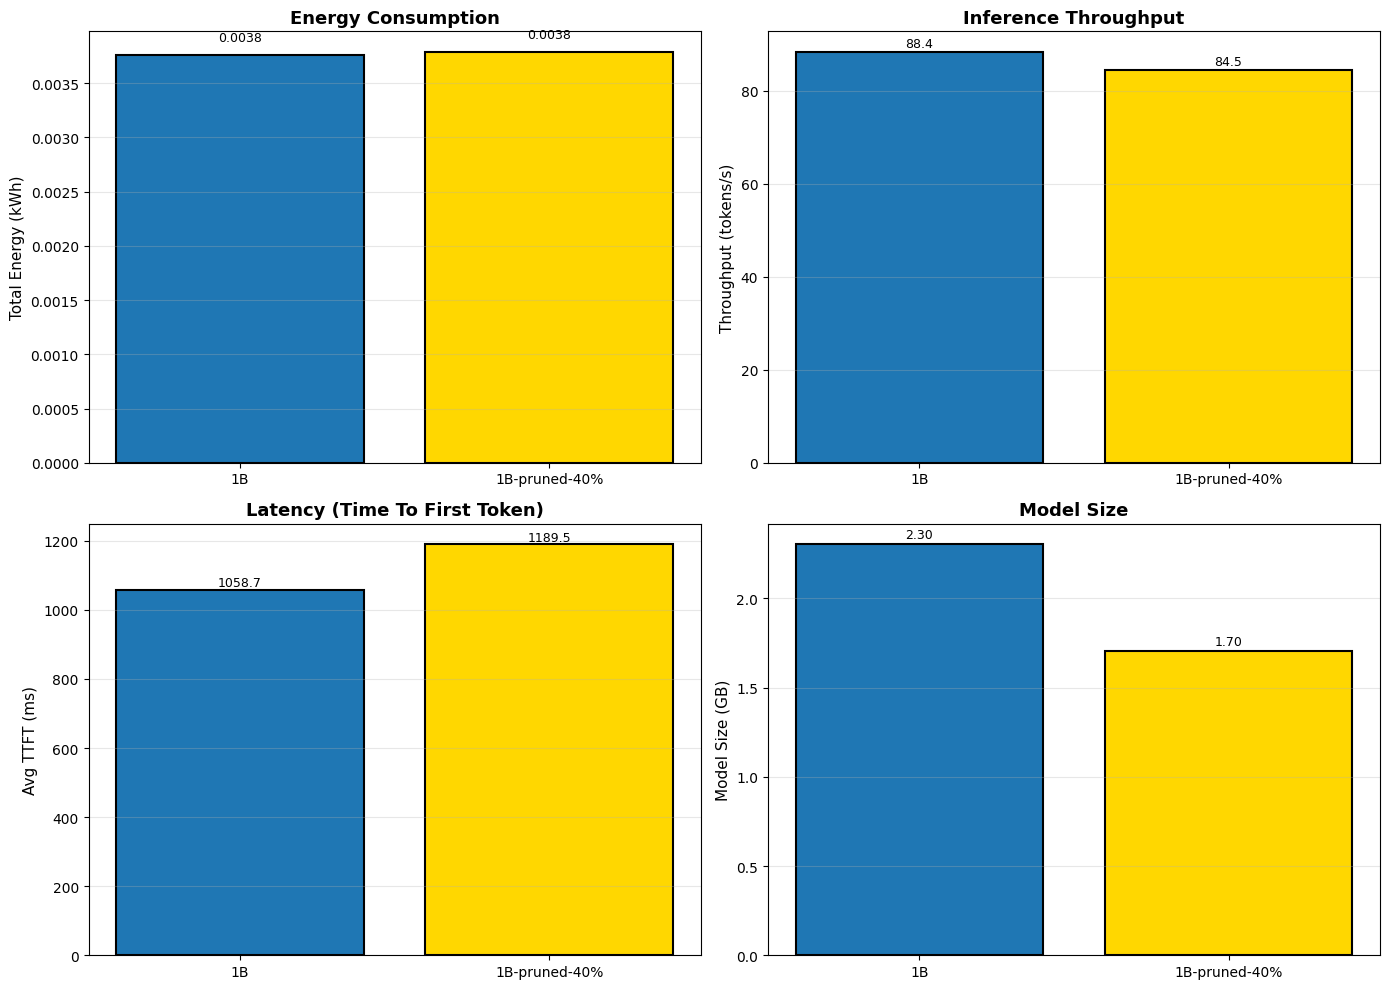


📊 Visualization saved to: /content/drive/MyDrive/glu_pruning/results/carbon_1b_analysis.png


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = summary_df['model'].values
pruning_levels = summary_df['pruning_pct'].values
star_mask = summary_df['is_star'].values

# Colors: baseline blue, star gold, others gray
colors = ['#1f77b4' if p == 0 else '#FFD700' if s else '#95a5a6'
          for p, s in zip(pruning_levels, star_mask)]

# 1. Energy Consumption
axes[0, 0].bar(range(len(models)), summary_df['total_energy_kwh'], color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_xticks(range(len(models)))
axes[0, 0].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[0, 0].set_ylabel('Total Energy (kWh)', fontsize=11)
axes[0, 0].set_title('Energy Consumption', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['total_energy_kwh']):
    axes[0, 0].text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# 2. Throughput
axes[0, 1].bar(range(len(models)), summary_df['avg_throughput_tok_s'], color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_xticks(range(len(models)))
axes[0, 1].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[0, 1].set_ylabel('Throughput (tokens/s)', fontsize=11)
axes[0, 1].set_title('Inference Throughput', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['avg_throughput_tok_s']):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 3. Latency (TTFT)
axes[1, 0].bar(range(len(models)), summary_df['avg_ttft_ms'], color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xticks(range(len(models)))
axes[1, 0].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[1, 0].set_ylabel('Avg TTFT (ms)', fontsize=11)
axes[1, 0].set_title('Latency (Time To First Token)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['avg_ttft_ms']):
    axes[1, 0].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 4. Model Size
axes[1, 1].bar(range(len(models)), summary_df['model_size_gb'], color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xticks(range(len(models)))
axes[1, 1].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[1, 1].set_ylabel('Model Size (GB)', fontsize=11)
axes[1, 1].set_title('Model Size', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['model_size_gb']):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/carbon_1b_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Visualization saved to: {RESULTS_DIR}/carbon_1b_analysis.png")

# 7. Decision Matrix: Which Models to Upload?

Based on the evaluation results, determine which models should be uploaded to HuggingFace Hub for Phase 2.


💾 SAVING COMPLETE RESULTS FOR RESEARCH SHARING

Loaded 1 expansion rates from config (Baseline included).
Dynamically built 7 model entries from 'df'.
✅ Complete results saved to:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_complete_results_20251023_091722.json
✅ Latest version:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_complete_results_latest.json

📊 File size: 17.5 KB

📦 Models included: 7
📋 Benchmarks per model: 13
🔬 Total result entries: 84

✅ COMPLETE RESULTS SAVED - Ready for research sharing



---

## 🎓 Key Takeaways

This notebook evaluated the Llama-3.2-1B model family across 10 comprehensive benchmarks to determine:

1. **Optimal pruning level** for GLU-MLP layers
2. **Performance-efficiency trade-offs** at different expansion ratios
3. **Which models justify upload** to HuggingFace Hub


---

**Powered by OptiPFair** - Structured Pruning for GLU Architectures

If this research helps your work:
- ⭐ Star [the repo](https://github.com/peremartra/optipfair)
- 📖 Read the [documentation](https://peremartra.github.io/optipfair/)
- 🐛 Report issues or suggest features

---